# Tutorial 5
## Outline
* Auto-differentiation frameworks: tensorflow and pytorch
* Nomenclatures and general components of training a NN
* PyTorch Tensors
* Building an NN with pytorch


## Tenserflow vs PyTorch

* PyTorch is developed by Facebook
* TensorFlow is developed by Google. Keras is a front-end API of TensorFlow.

### Similarities
* Both are auto-differentiation framework
* Both are open source
* Both support CPU and GPU executions
* Both have a large and active community

### Dissimilarities
#### Graph structure
* Depending on version, TensorFlow is either static graph (version 1) or dynamic graph (version 2, with eager execution), but not as efficient as static graph
* PyTorch is completely dynamic graph, and is efficient (sometimes even more efficient than TF with static graph!)


#### Language support
* TensorFlow supports a large variety of languages, i.e. C++, JavaScript, Python, C#, Ruby, and Swift.
* PyTorch only supports python

#### Deployment
* Tensorflow can be easily deployed into different platforms, including mobile devices!
* PyTorch code has to be converted into a different framework for depolyment

### General suggestions
* TensorFlow (with Keras) is easier to use for trying out existing models on a new dataset with minimal modifications on the architecture
* It is also good for building simple models, like MLP networks 
* PyTorch is more useful in research, when you would like to try complicated NN architectures and needs to do a lot of debuggingg and validation of ideas, but do not care about deployment

## Nomenclatures and general components of training a NN
* **Epoch**: Going through training data once
* **Batch**: Set of data for calculating each gradient update
* **Batch size**: Size of data in a batch
* **Iteration**: One iteration = one gradient update
* **Learning rate**: Coefficient multiplied to the gradient in each update

### Neural network architecture
* Multiple layer perceptron (MLP)
* Convolutional neural network (CNN)
* Graph convolutional neural network (GCN)
* Recurrent neural network (RNN)
* AutoEncoder (AE) 
* Attention mechanism / Transformer 
* ...

### Optimizer
* SGD (SGDM)
* Adam
* RMSProp
* ...

### Loss function
* Mean squared error (MSE)
* Mean absolute error (MAE)
* Cosine similarity 
* Binary crossentropy (CE) 
* Categorical crossentropy
* ...

## PyTorch: Tensors

Here we introduce the most fundamental PyTorch concept: the **Tensor**. A PyTorch Tensor is conceptually identical to a numpy array: a Tensor is an n-dimensional array, and PyTorch provides many functions for operating on these Tensors. Behind the scenes, Tensors can keep track of a computational graph and gradients, but they’re also useful as a generic tool for scientific computing.

In [2]:
import torch
import numpy as np

a = torch.tensor([[0.1, 1.2], [2.2, 3.1], [4.9, 5.2]])
a.size()

torch.Size([3, 2])

In [5]:
a.reshape(-1) #flatten array

tensor([0.1000, 1.2000, 2.2000, 3.1000, 4.9000, 5.2000])

In [9]:
x = torch.linspace(-np.pi, 2, 20)
x

tensor([-3.1416, -2.8710, -2.6004, -2.3298, -2.0592, -1.7885, -1.5179, -1.2473,
        -0.9767, -0.7061, -0.4355, -0.1649,  0.1057,  0.3763,  0.6469,  0.9176,
         1.1882,  1.4588,  1.7294,  2.0000])

Convert numpy array to torch and vice versa

In [10]:
a = np.ones((3,2))
type(a)

numpy.ndarray

In [15]:
b = torch.tensor(a, dtype=torch.float64)
b

tensor([[1., 1.],
        [1., 1.],
        [1., 1.]], dtype=torch.float64)

In [16]:
b.detach().numpy()

array([[1., 1.],
       [1., 1.],
       [1., 1.]])

Specify the device and data types for torch tensors

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float
a = torch.randn((2, 3), device = device, dtype = dtype)

In [19]:
a.to(torch.device("cpu"))

tensor([[-0.8512, -1.3831,  0.1426],
        [-0.0201,  0.2908,  0.3900]])

## Building NN for regression task
For example, let's use a two hidden-layer MLP network [20, 15, 1] to simulate the Rosenbrock banana function!<br>
$f(x,y)=(1-x)^2+10(y-x^2)^2$<br>
$x\in[-2,2],y\in[-2,2]$

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

def generate_X(number):
    xs=(np.random.random(number)*2-1)*2
    ys=(np.random.random(number)*2-1)*2
    return np.hstack([xs.reshape(-1,1),ys.reshape(-1,1)])
    
def generate_data(number,stochascity=0.05):
    X=generate_X(number)
    xs=X[:,0]
    ys=X[:,1]
    fs=(1-xs)**2+10*(ys-xs**2)**2
    stochastic_ratio=(np.random.random(number)*2-1)*stochascity+1
    return np.hstack([xs.reshape(-1,1),ys.reshape(-1,1)]),fs*stochastic_ratio

<IPython.core.display.Javascript object>


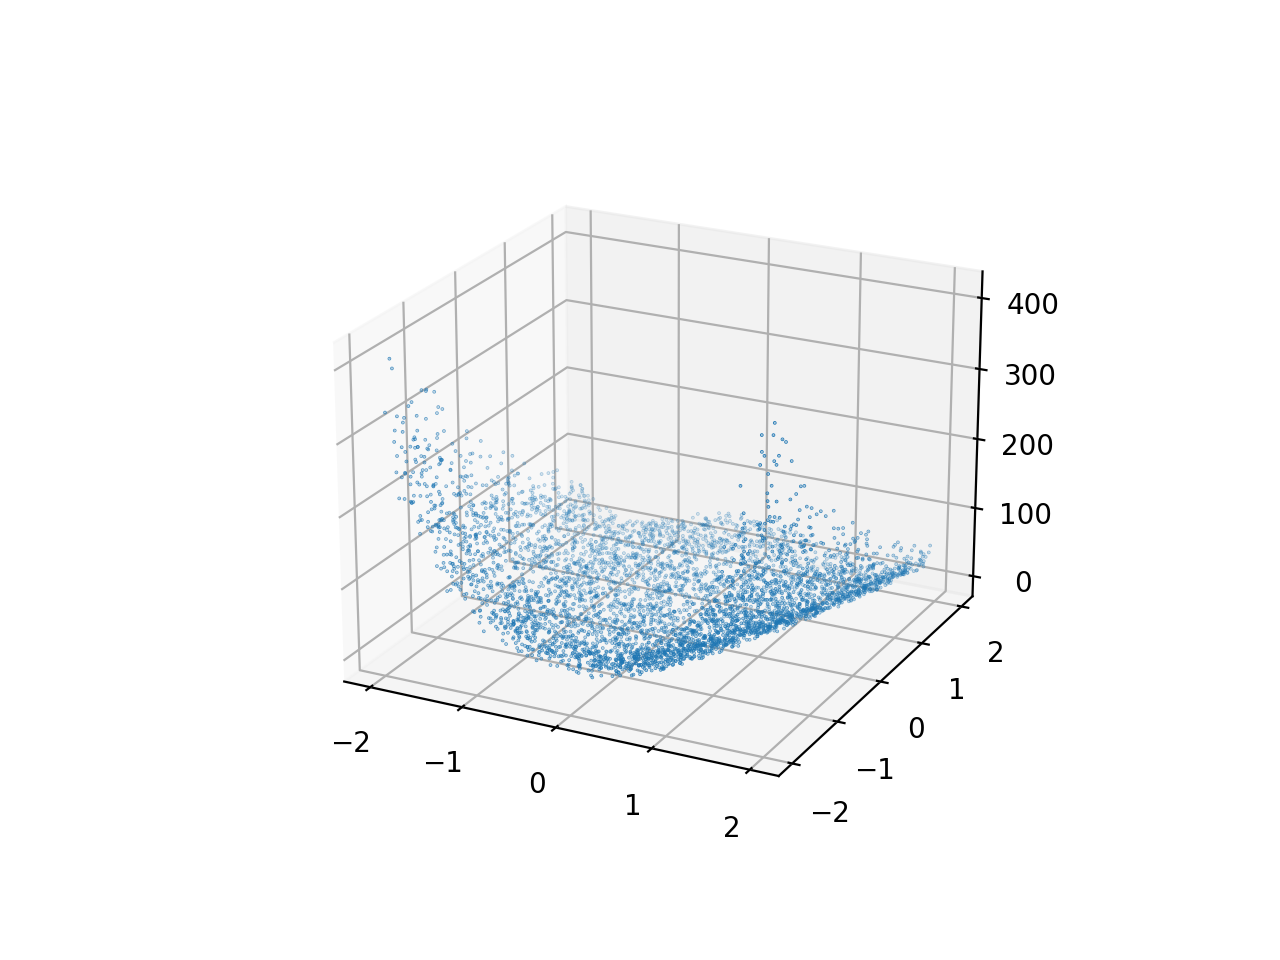

In [22]:
x, y = generate_data(5000, 0.3)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x[:, 0], x[:, 1], y, s=0.1)

### Building a PyTorch model

In [23]:
from torch import nn
import torch

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 20),
            nn.ReLU(),
            nn.Linear(20, 15),
            nn.ReLU(),
            nn.Linear(15, 1)
        )
        
    def forward(self, x):
        return self.layers(x)

In [32]:
model = MLP()
weights = model.state_dict()
weights
#rebuild model from weights
model.load_state_dict(weights)
#print(model)

<All keys matched successfully>

In [33]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

best_loss = float('inf')
best_weights = []

for i in range(100):
    train_X, train_y = generate_data(128, stochascity=0.1)
    train_X = torch.tensor(train_X, dtype=torch.float)
    train_y = torch.tensor(train_y, dtype=torch.float)
    pred = model(train_X)
    loss = loss_func(pred, train_y.reshape(-1, 1))
    ##set optimizer grad to zero, important,before step()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if loss.item() < best_loss:
        best_weights = model.state_dict()
        best_loss = loss.item()
    print("Iteration %d: Loss value - %.4f" % (i + 1, loss.item()))
    
model.load_state_dict(best_weights)

Iteration 1: Loss value - 6896.1704
Iteration 2: Loss value - 8360.2490
Iteration 3: Loss value - 5170.0332
Iteration 4: Loss value - 6602.7012
Iteration 5: Loss value - 4454.3823
Iteration 6: Loss value - 6027.8281
Iteration 7: Loss value - 6428.7363
Iteration 8: Loss value - 6422.1436
Iteration 9: Loss value - 5722.2593
Iteration 10: Loss value - 6621.1963
Iteration 11: Loss value - 4251.2363
Iteration 12: Loss value - 4420.5791
Iteration 13: Loss value - 5611.6523
Iteration 14: Loss value - 4946.0415
Iteration 15: Loss value - 4680.6753
Iteration 16: Loss value - 7689.1440
Iteration 17: Loss value - 4691.2031
Iteration 18: Loss value - 5695.9673
Iteration 19: Loss value - 6326.8828
Iteration 20: Loss value - 6442.0684
Iteration 21: Loss value - 4937.1401
Iteration 22: Loss value - 5185.3823
Iteration 23: Loss value - 7532.8872
Iteration 24: Loss value - 6175.8335
Iteration 25: Loss value - 4931.5244
Iteration 26: Loss value - 5142.3589
Iteration 27: Loss value - 6236.2461
Iteration 

<All keys matched successfully>

<IPython.core.display.Javascript object>


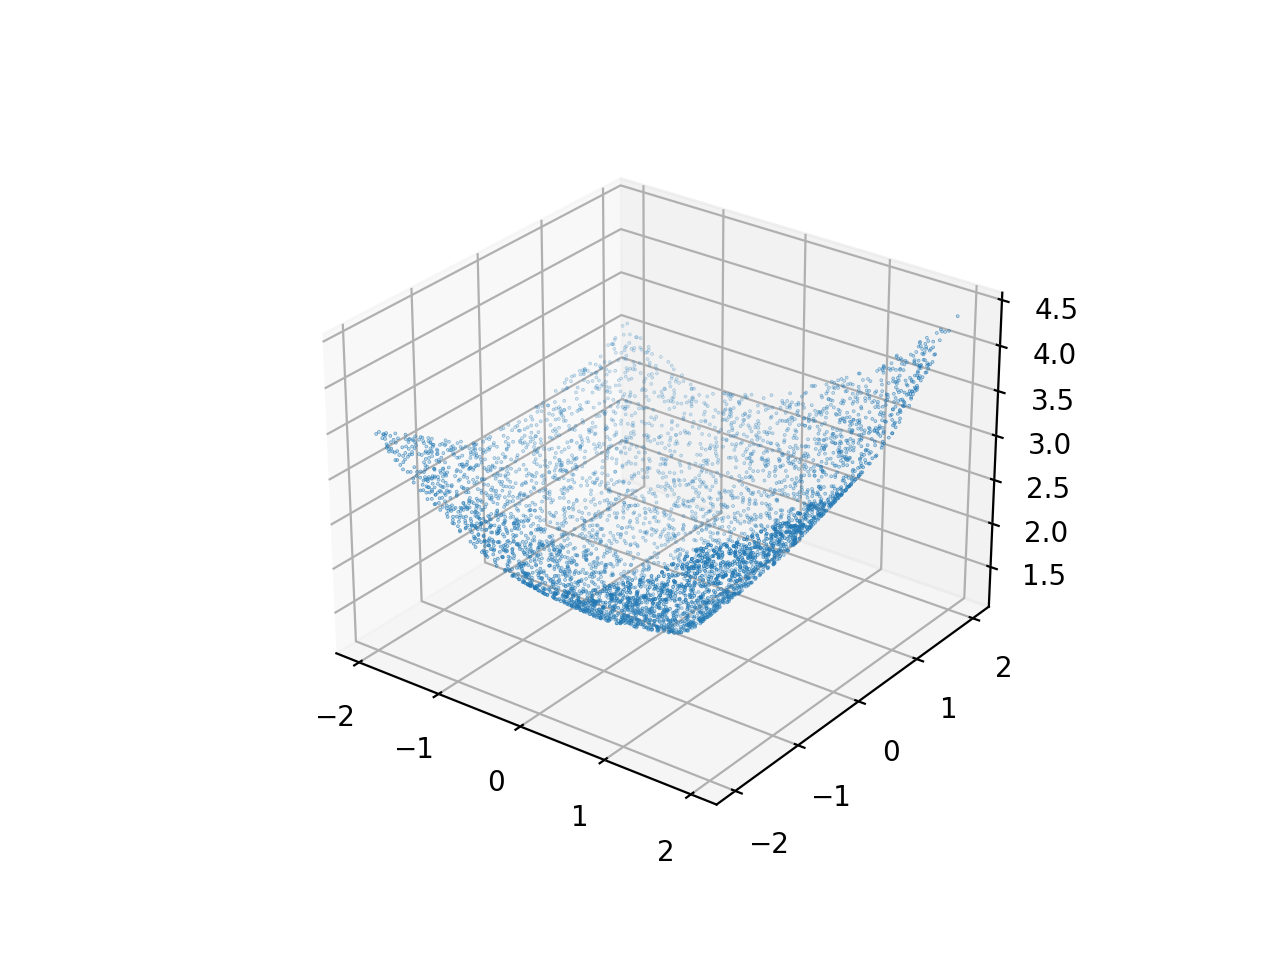

In [34]:
new_X = generate_X(5000)
with torch.no_grad():
    new_y = model(torch.tensor(new_X, dtype=torch.float))
new_y = new_y.detach().numpy()
fig = plt.figure()
ax=fig.add_subplot(projection='3d')
ax.scatter(new_X[:, 0], new_X[:, 1], new_y, s=0.1)